This notebook presents statistics of the book data integration.

## Setup


In [1]:
library(tidyverse, warn.conflicts=FALSE)
library(arrow, warn.conflicts=FALSE)
library(jsonlite)

In [2]:
options(fig.width=5, fig.height=4)

## Load Link Stats

We compute dataset linking statistics as `gender-stats.csv` as part of the integration.  Let's load those:


In [3]:
link_stats = read_csv("book-links/gender-stats.csv")
glimpse(link_stats)

Rows: 46 Columns: 4


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): dataset, gender
dbl (2): n_books, n_actions



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 46
Columns: 4
$ dataset   <chr> "LOC-MDS", "LOC-MDS", "LOC-MDS", "LOC-MDS", "LOC-MDS", "LOC-…
$ gender    <chr> "no-author-rec", "no-book-author", "female", "ambiguous", "m…
$ n_books   <dbl> 306291, 600216, 743105, 73989, 2424008, 1084460, 9528, 10861…
$ n_actions <dbl> NA, NA, NA, NA, NA, NA, 104008, 18882, 47275, 468156, 18597,…


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:


In [4]:
link_codes = c('female', 'male', 'ambiguous', 'unknown')

We want the unlink codes in order, so the last is the first link failure:


In [5]:
unlink_codes = c('no-author-rec', 'no-book-author', 'no-book')

In [6]:
all_codes = c(link_codes, unlink_codes)

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.


In [7]:
book_counts = link_stats %>%
    pivot_wider(id_cols=dataset, names_from=gender, values_from=n_books) %>%
    replace(is.na(.), 0) %>%
    mutate(total=rowSums(across(-dataset)))
glimpse(book_counts)

Rows: 7
Columns: 9
$ dataset          <chr> "LOC-MDS", "BX-I", "BX-E", "AZ14", "AZ18", "GR-I", "G…
$ `no-author-rec`  <dbl> 306291, 11562, 5692, 155511, 239917, 61601, 60515
$ `no-book-author` <dbl> 600216, 10861, 5428, 167948, 152438, 750118, 738282
$ female           <dbl> 743105, 71441, 40256, 248863, 318004, 228142, 225840
$ ambiguous        <dbl> 73989, 9528, 5596, 24064, 27977, 18709, 18516
$ male             <dbl> 2424008, 102756, 58484, 550877, 670899, 338411, 334136
$ unknown          <dbl> 1084460, 31440, 15281, 239915, 300300, 108333, 106501
$ `no-book`        <dbl> 0, 35009, 17481, 870268, 1144899, 0, 0
$ total            <dbl> 5232069, 272597, 148218, 2257446, 2854434, 1505314, 1…


In [8]:
act_counts = link_stats %>%
    filter(dataset != "LOC-MDS") %>%
    pivot_wider(id_cols=dataset, names_from=gender, values_from=n_actions) %>%
    replace(is.na(.), 0) %>%
    mutate(total=rowSums(across(-dataset)))
glimpse(act_counts)

Rows: 6
Columns: 9
$ dataset          <chr> "BX-I", "BX-E", "AZ14", "AZ18", "GR-I", "GR-E"
$ ambiguous        <dbl> 104008, 41768, 849025, 1844630, 22091068, 13230835
$ `no-book-author` <dbl> 18882, 7234, 2359170, 2820794, 29784689, 11168052
$ `no-book`        <dbl> 47275, 19920, 3879190, 10008921, 0, 0
$ male             <dbl> 468156, 183945, 7105363, 15603235, 69977512, 33249747
$ `no-author-rec`  <dbl> 18597, 7130, 1100127, 3312340, 3545964, 1039410
$ female           <dbl> 401483, 142252, 4977284, 12377052, 82889862, 36335167
$ unknown          <dbl> 69361, 24554, 2157265, 4692726, 10242726, 3570086
$ total            <dbl> 1127762, 426803, 22427424, 50659698, 218531821, 98593…


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:


In [9]:
fractionalize = function(data, columns, unlinked=NULL) {
    fracs = select(data, dataset | all_of(columns))
    if (!is.null(unlinked)) {
        fracs = mutate(fracs, unlinked=rowSums(select(data, all_of(columns))))
    }
    totals = rowSums(select(fracs, !dataset))
    fracs %>% mutate(across(!dataset, ~ .x / totals))
}
fractionalize(book_counts, link_codes) %>% glimpse()

Rows: 7
Columns: 5
$ dataset   <chr> "LOC-MDS", "BX-I", "BX-E", "AZ14", "AZ18", "GR-I", "GR-E"
$ female    <dbl> 0.1717939, 0.3320289, 0.3365408, 0.2339556, 0.2414279, 0.328…
$ male      <dbl> 0.5603915, 0.4775684, 0.4889272, 0.5178783, 0.5093450, 0.487…
$ ambiguous <dbl> 0.01710506, 0.04428229, 0.04678265, 0.02262252, 0.02124007, …
$ unknown   <dbl> 0.2507096, 0.1461204, 0.1277494, 0.2255436, 0.2279871, 0.156…


And a helper function for plotting bar charts:


In [10]:
plot_bars = function(data) {
    tall = data %>%
        pivot_longer(!dataset, names_to="status", values_to="fraction")
    codes = c(all_codes, "unlinked")
    codes = intersect(codes, unique(tall$status))
    tall = tall %>% mutate(status=ordered(status, codes))
    ggplot(tall) +
        aes(y=dataset, x=fraction, fill=status) +
        geom_col(position=position_stack(reverse=TRUE)) +
        geom_text(aes(label=sprintf("%.1f%%", fraction * 100)),
                  position=position_stack(reverse=TRUE, vjust=0.5),
                  colour="white", fontface="bold") +
        scale_fill_brewer(type="qual", palette="Dark2")
}

## Resolution of Books

What fraction of *unique books* are resolved from each source?


In [11]:
book_counts %>% fractionalize(all_codes)

dataset,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LOC-MDS,0.1420289,0.4632982,0.014141442,0.20727173,0.05854109,0.11471867,0.0000000
BX-I,0.2620755,0.3769521,0.034952696,0.11533509,0.04241426,0.03984270,0.1284277
BX-E,0.2715999,0.3945810,0.037755198,0.10309814,0.03840289,0.03662173,0.1179411
AZ14,0.1102410,0.2440267,0.010659834,0.10627718,0.06888803,0.07439735,0.3855100
AZ18,0.1114070,0.2350375,0.009801243,0.10520474,0.08405064,0.05340393,0.4010949
GR-I,0.1515577,0.2248109,0.012428636,0.07196704,0.04092236,0.49831331,0.0000000
GR-E,0.1522048,0.2251909,0.012478855,0.07177633,0.04078407,0.49756502,0.0000000


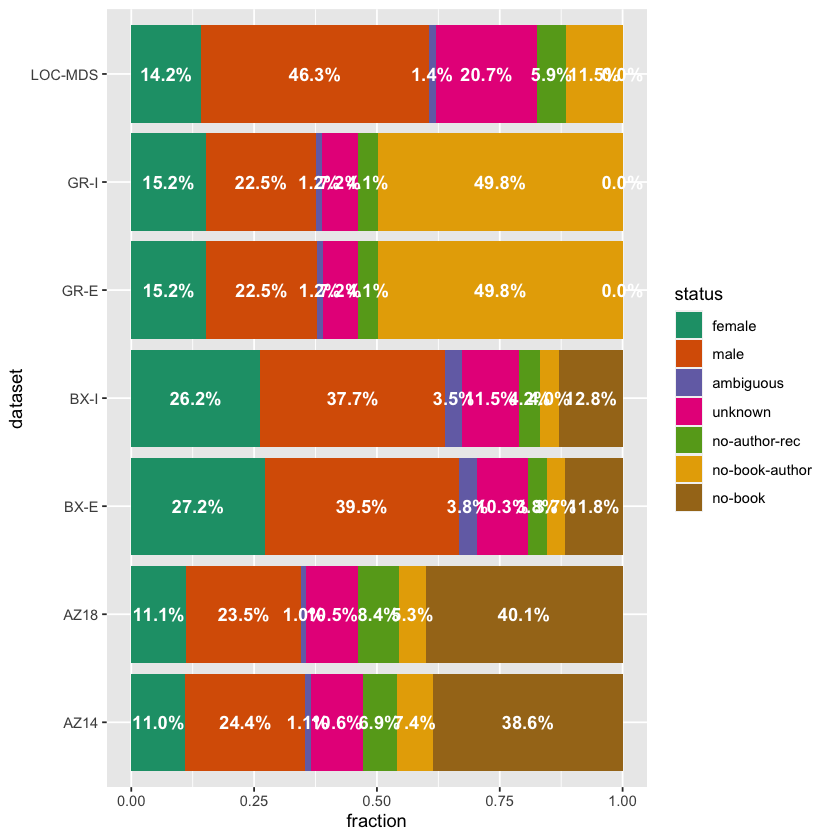

In [12]:
book_counts %>% fractionalize(all_codes) %>% plot_bars()

In [13]:
book_counts %>% fractionalize(link_codes, unlink_codes)

dataset,female,male,ambiguous,unknown,unlinked
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LOC-MDS,0.08589693,0.2801957,0.00855253,0.12535481,0.5
BX-I,0.16601445,0.2387842,0.02214115,0.07306021,0.5
BX-E,0.16827040,0.2444636,0.02339132,0.06387470,0.5
AZ14,0.11697779,0.2589392,0.01131126,0.11277179,0.5
AZ18,0.12071395,0.2546725,0.01062004,0.11399353,0.5
GR-I,0.16446341,0.2439543,0.01348698,0.07809529,0.5
GR-E,0.16484840,0.2438974,0.01351547,0.07773875,0.5


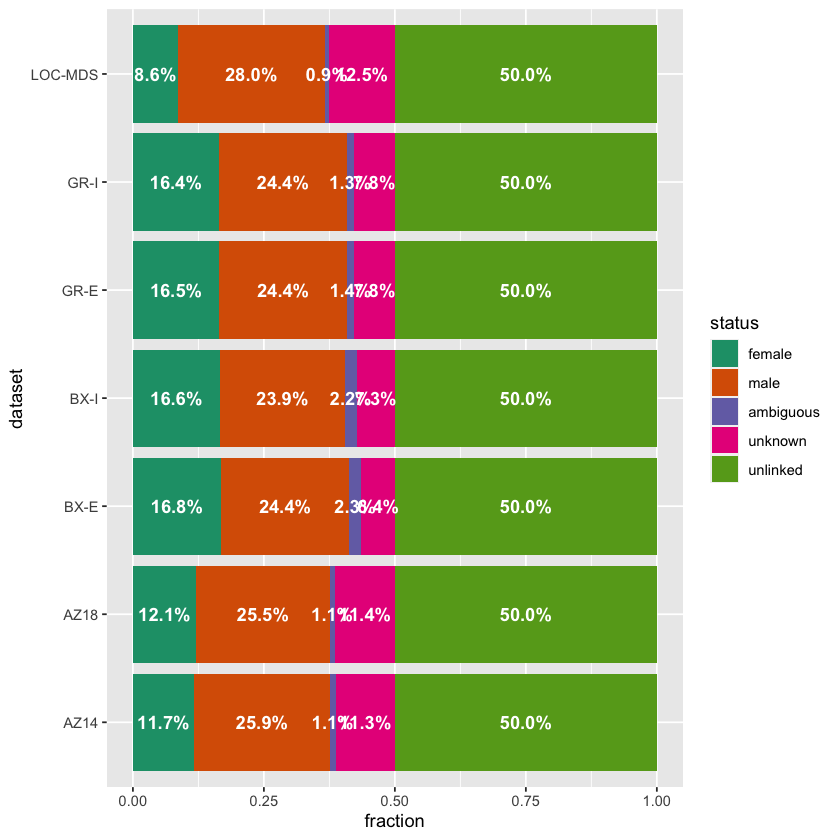

In [14]:
book_counts %>% fractionalize(link_codes, unlink_codes) %>% plot_bars()

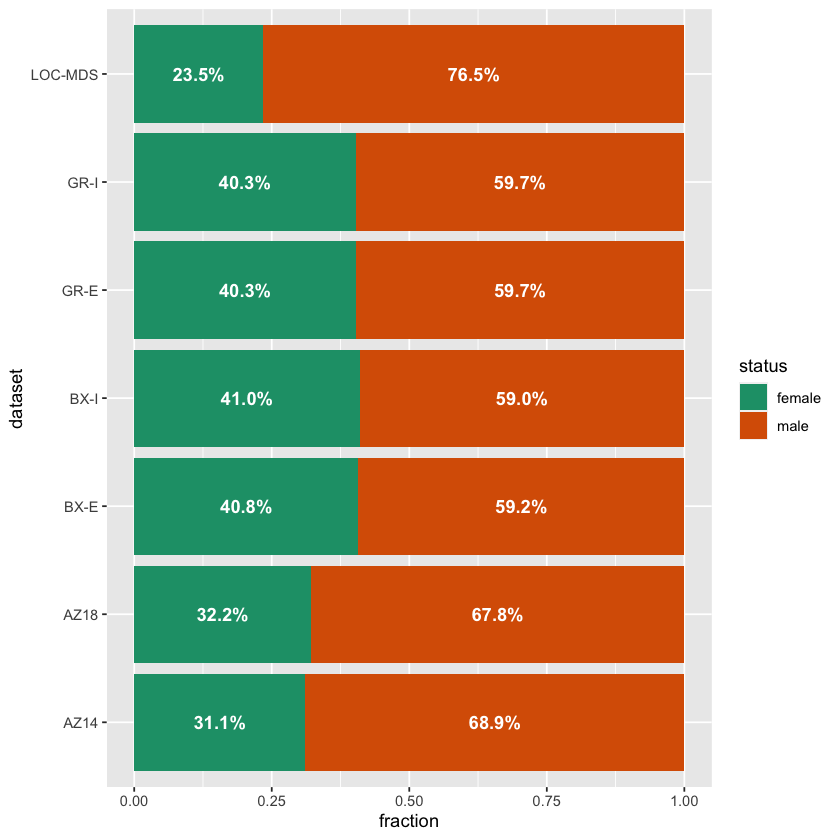

In [15]:
book_counts %>% fractionalize(c('female', 'male')) %>% plot_bars()

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?


In [16]:
act_counts %>% fractionalize(all_codes)

dataset,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BX-I,0.3559998,0.4151195,0.09222513,0.06150322,0.01649018,0.01674289,0.04191931
BX-E,0.3332966,0.4309834,0.09786248,0.05753005,0.01670560,0.01694927,0.04667259
AZ14,0.2219285,0.3168158,0.03785655,0.09618871,0.04905276,0.10519131,0.17296636
AZ18,0.2443175,0.3080009,0.03641218,0.09263233,0.06538412,0.05568122,0.19757167
GR-I,0.3793034,0.3202166,0.10108856,0.04687064,0.01622631,0.13629452,0.00000000
GR-E,0.3685359,0.3372415,0.13419609,0.03621023,0.01054240,0.11327395,0.00000000


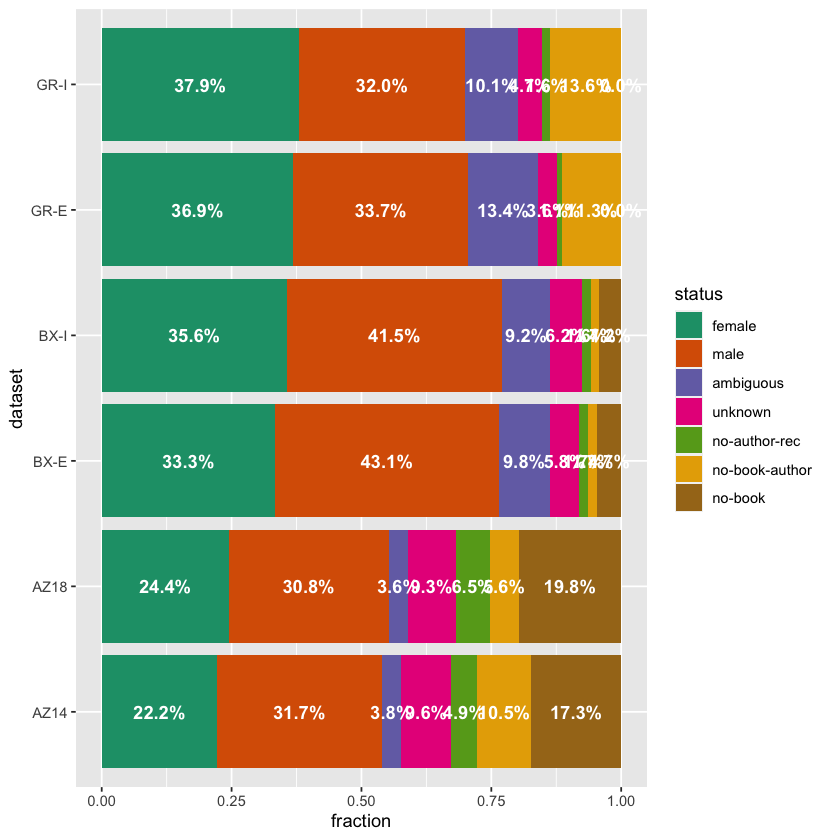

In [17]:
act_counts %>% fractionalize(all_codes) %>% plot_bars()

In [18]:
act_counts %>% fractionalize(link_codes, unlink_codes)

dataset,female,male,ambiguous,unknown,unlinked
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BX-I,0.1924640,0.2244259,0.04985964,0.03325046,0.5
BX-E,0.1812040,0.2343135,0.05320507,0.03127747,0.5
AZ14,0.1649316,0.2354494,0.02813402,0.07148499,0.5
AZ18,0.1792859,0.2260183,0.02672010,0.06797576,0.5
GR-I,0.2237833,0.1889230,0.05964074,0.02765297,0.5
GR-E,0.2103074,0.1924491,0.07657989,0.02066361,0.5


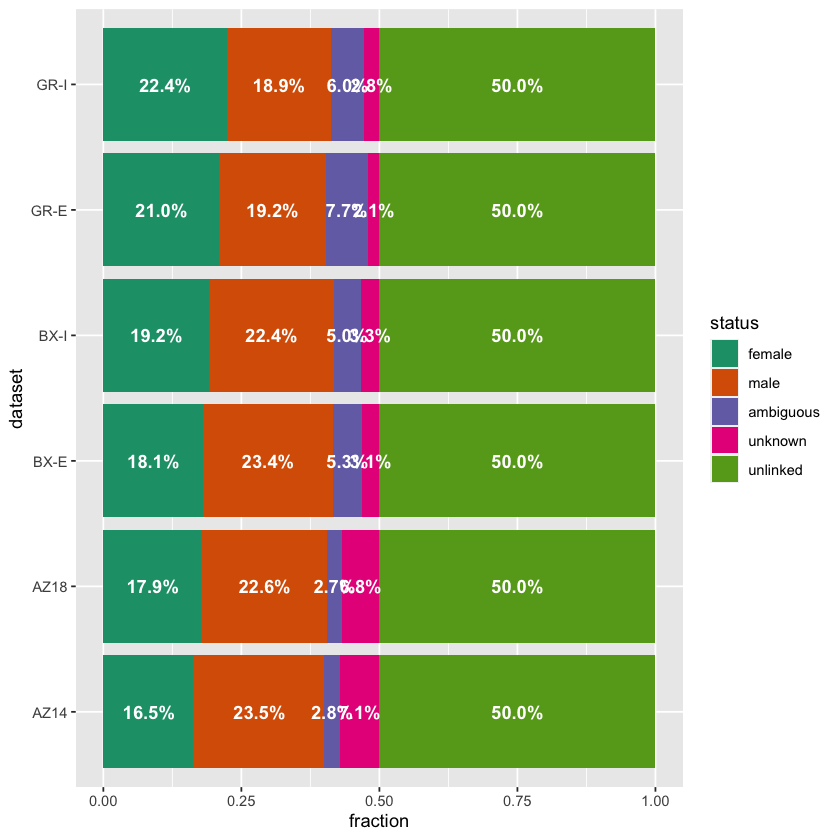

In [19]:
act_counts %>% fractionalize(link_codes, unlink_codes) %>% plot_bars()

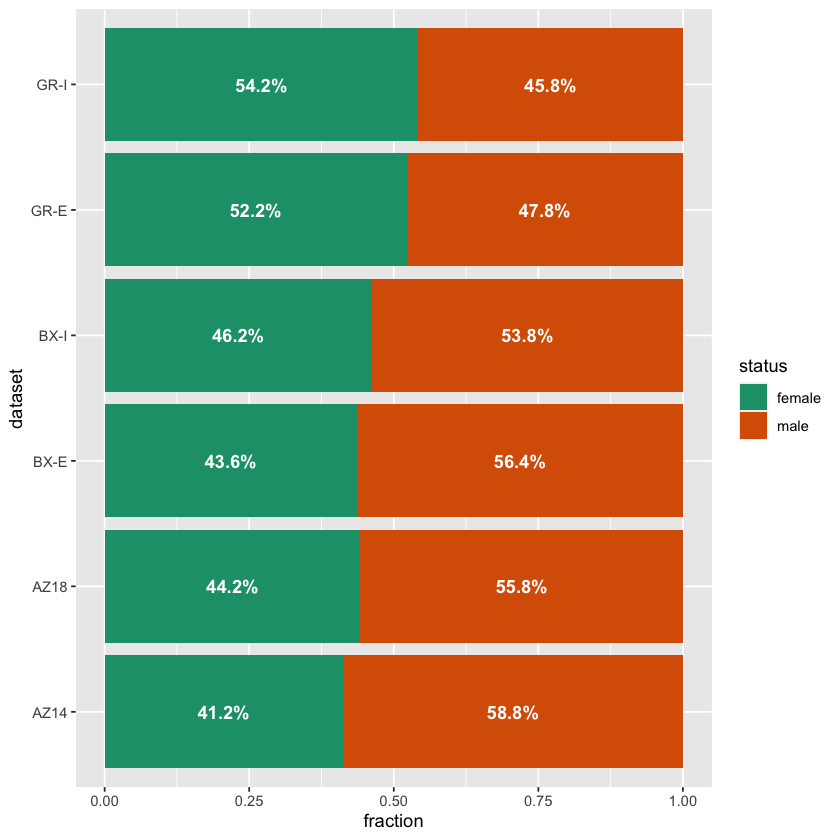

In [20]:
act_counts %>% fractionalize(c('female', 'male')) %>% plot_bars()

## Metrics

Finally, we're going to write coverage metrics.


In [21]:
book_linked = eval(quote(male + female + ambiguous), envir=book_counts)
book_coverage = book_linked / book_counts$total
book_coverage = setNames(book_coverage, book_counts$dataset)
book_coverage

LOC-MDS      BX-I      BX-E      AZ14      AZ18      GR-I      GR-E 
0.6194685 0.6739803 0.7039361 0.3649274 0.3562458 0.3887973 0.3898746

In [22]:
json = toJSON(
    as.list(book_coverage),
    auto_unbox=TRUE,
)
write_file(json, "book-coverage.json")